In [9]:
# Standard python helper libraries.

import json, os, re, shutil, sys, time
import itertools, collections
from importlib import reload
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# NumPy and SciPy for matrix ops
import numpy as np
import scipy.sparse
import pandas as pd
import tensorflow as tf
assert(tf.__version__.startswith("1."))
from sklearn.cross_validation import train_test_split

# NLTK for NLP utils
import nltk
import gzip
from collections import namedtuple
# Helper libraries
from w266_common import vocabulary, tf_embed_viz, glove_helper
from w266_common import utils; reload(utils)
import rnnlm; reload(rnnlm)

<module 'rnnlm' from '/home/reachanamikasinha/project/rnnlm.py'>

In [2]:
#Using pretrained GLove embeddings
hands = glove_helper.Hands(ndim=100)  # 50, 100, 200, 300 dim are available

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


In [3]:
hands.shape

(400003, 100)

In [7]:
#Function to read the amazon review data files
def parse(path):
  print('start parse')
  start_parse = time.time()
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
  end_parse = time.time()
  print('end parse with time for parse',end_parse - start_parse)

def getDF(path):
  print('start getDF')
  start = time.time()
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  print('end getDF')
  end = time.time()
  print('time taken to load data = ',end-start)
  return pd.DataFrame.from_dict(df, orient='index')
#df = getDF('reviews_Toys_and_Games.json.gz') #old def function corresponding to the step bt step vectorization

In [10]:
df_hnk = getDF('reviews_Home_and_Kitchen.json.gz')

start getDF
start parse
end parse with time for parse 210.61572980880737
end getDF
time taken to load data =  210.61674904823303


In [ ]:
df_vid = getDF('reviews_Video_Games.json.gz')

In [ ]:
df_aut = getDF('reviews_Automotive.json.gz')

In [ ]:
df_toys = getDF('reviews_Toys_and_Games.json.gz')

In [11]:
#Create train,dev,test split
from sklearn.model_selection import train_test_split
# train_toys,devtest = train_test_split(df_toys, test_size=0.4, random_state=42)
# dev_toys,test_toys = train_test_split(devtest,test_size = 0.5, random_state=42)
# print('Toy reviews train, dev and test set dataframe shape:',train_toys.shape,dev_toys.shape,test_toys.shape)

#For Video games reviews
# train_vid,devtest = train_test_split(df_vid, test_size=0.4)
# dev_vid,test_vid = train_test_split(devtest,test_size = 0.5)
# print('Video games reviews train, dev and test set dataframe shape:',train_vid.shape,dev_vid.shape,test_vid.shape)

#For Auto reviews
# train_aut,devtest = train_test_split(df_aut, test_size=0.4)
# dev_aut,test_aut = train_test_split(devtest,test_size = 0.5)
# print('Auto reviews train, dev and test set dataframe shape:',train_aut.shape,dev_aut.shape,test_aut.shape)

#For Home and Kitchen reviews
train_hnk,devtest = train_test_split(df_hnk, test_size=0.4)
dev_hnk,test_hnk = train_test_split(devtest,test_size = 0.5)
print('Home and Kitchen reviews train, dev and test set dataframe shape:',train_hnk.shape,dev_hnk.shape,test_hnk.shape)

Home and Kitchen reviews train, dev and test set dataframe shape: (2552355, 9) (850785, 9) (850786, 9)


In [14]:
#checking that we have different productids
print(train_hnk.head(5))

             reviewerID        asin                             reviewerName  \
2624198   ASUB02QF54XHO  B003US4L4K                                      ChR   
2203026  A3M82GUHMPNQEA  B002PABWJQ                                      Rae   
1289454   AC46D9HI8ZK88  B000RH173A  Sirens List                     Florida   
3244748  A3K9ZXPTAQLQ1J  B005L3NIRS                                monkey893   
525993    AVCKAQN2TFMTS  B0002IES80                             Peter Hurley   

        helpful                                         reviewText  overall  \
2624198  [0, 0]  Useful little storage box for rechargeable AA ...      4.0   
2203026  [0, 0]  I purchased this tool along with the Artisan B...      5.0   
1289454  [0, 0]  I AM IN LOOOOVE WITH THESE BLACK SATIN SHEETS....      5.0   
3244748  [0, 0]  The whole brew cycle for a full 10 cups under ...      1.0   
525993   [1, 1]  I just bought this item and have used it for s...      5.0   

                                          su

In [17]:
#Function to create a smaller sized train and dev data set. Enables testing accuracy for different sizes.
#Also binarizes the labels. Ratings of 1,2 and to 0; Ratings of 4,5 to 1.

def set_df_size(size,data_train,data_dev):
    size_train = size
    len_max_train = data_train[data_train.overall!=3].shape[0] #max possible length of train data set taking out the 3 ratings.
    #print("Number of reviews with ratings != 3 in train set",len_max_train)
    temp_size_train = min(len_max_train,size_train)

    len_max_dev = data_dev[data_dev.overall!=3].shape[0]
    #print("Number of reviews with ratings != 3 in dev set",len_max_dev)
    temp_size_dev = min(len_max_dev,int(0.3*temp_size_train)) #making the dev set about 0.3 times the train set.

    temp_train_data = data_train[data_train.overall != 3][:temp_size_train]
    #print('Size of train data',temp_train_data.shape)
    #print(temp_train_data.groupby('overall').count())
    #print(temp_train_toys[:5])

    temp_dev_data = data_dev[data_dev.overall!=3][:temp_size_dev]
    #print('Size of dev data',temp_dev_data.shape)
    #print(temp_dev_data.groupby('overall').count())
    #print(temp_dev_data[:2])
    
    #Binarize ratings
    temp_train_y = np.zeros(temp_size_train)
    temp_train_y[temp_train_data.overall > 3] = 1
    temp_dev_y = np.zeros(temp_size_dev)
    temp_dev_y[temp_dev_data.overall>3] = 1
    #print('binarized y shape',temp_train_y.shape,temp_dev_y.shape)
    #print(temp_dev_y[:20],data_dev.overall[:20])
    return temp_train_data,temp_dev_data,temp_train_y,temp_dev_y

In [15]:
print(print(dev_hnk.head(5)))

             reviewerID        asin reviewerName helpful  \
2619903  A32PA6OI1IV6AR  B003UDUH5W        Kevin  [0, 0]   
1604019  A3GD869ZCKAFQV  B0018DXA5K     Paul-101  [0, 0]   
3204287  A2CZMVXIR370RV  B005GPVN5K      Charles  [0, 0]   
1879236  A3ATUV2XNCL93J  B001O2SNGG      Maureen  [0, 0]   
235028   A2H36CZZNTDQCR  B00006JSUA     N. Monti  [0, 0]   

                                                reviewText  overall  \
2619903  It's very good overall but the only problem is...      4.0   
1604019  I try the CervAlign Pillow for 7 nights..........      1.0   
3204287  Very easy to use and wife loves it! Cleaned ou...      5.0   
1879236  The first few times I used this it worked grea...      2.0   
235028   I was so excited to receive this skillet.  It ...      4.0   

                                                   summary  unixReviewTime  \
2619903  Great quality but the bottom holes are a bit t...      1402704000   
1604019                                             Pill

In [18]:
list_df = ['toys','vid','aut','hnk'] #list of keys that refer to each dataframe. Adding a new dataframe would require updating this list
dict_train_df = {} #Dict to store train input data frame for each domain, can be accessed by using domain name as key
dict_dev_df = {} #Dict to store dev input data frame for each domain, can be accessed by using domain name as key
dict_train_y = {} #Dict to store binarized train data label for each domain
dict_dev_y = {} #Dict to store binarized dev data label for each domain
#print(len(dict_train_df))

def create_sized_data(size = 10000):
    size_train = size #Set size of train set here. This is a hyperparameter.
#     key = list_df[0]
    #print('Toys reviews\n')
#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_toys,dev_toys)
#     #print('\n Video games reviews\n')
#     key = list_df[1]
#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_vid,dev_vid)
#     #print('\n Auto reviews\n')
#     key = list_df[2]
#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_aut,dev_aut)
    #print('\n Home and Kitchen reviews\n')
    key = list_df[3]
    dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_hnk,dev_hnk)
    
create_sized_data()
#print(len(dict_train_df))

In [23]:
list_df = ['toys','vid','aut','hnk'] #list of keys that refer to each dataframe. Adding a new dataframe would require updating this list
dict_train_df = {} #Dict to store train input data frame for each domain, can be accessed by using domain name as key
dict_dev_df = {} #Dict to store dev input data frame for each domain, can be accessed by using domain name as key
dict_train_y = {} #Dict to store binarized train data label for each domain
dict_dev_y = {} #Dict to store binarized dev data label for each domain
#print(len(dict_train_df))

def create_sized_data(size = 10000):
    size_train = size #Set size of train set here. This is a hyperparameter.
    key = list_df[3]
    #print('Toys reviews\n')

#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_toys,dev_toys)
#     #print('\n Video games reviews\n')
#     key = list_df[1]
#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_vid,dev_vid)
#     #print('\n Auto reviews\n')
#     key = list_df[2]
#     dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_aut,dev_aut)
#     #print('\n Home and Kitchen reviews\n')
    key = list_df[3]
    dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_hnk,dev_hnk)
    
create_sized_data()
#print(len(dict_train_df))

In [21]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize


[nltk_data] Downloading package punkt to
[nltk_data]     /home/reachanamikasinha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
print(dict_train_df['hnk'].shape[0])

10000


In [9]:
#Preprocessing steps

#Changing to nltk punkt tokenizer as the periods are not getting removed
print(dict_train_df[key].shape[0])

train_cnt = collections.Counter()
x_train_tokens_list = []
start = time.time()
for i in range(X_train.shape[0]):

    x_train_tokens = word_tokenize(X_train.iloc[i])
    
    

    #2. changing to lowercase and replacing numbers(are we losing any context by 
    #replacing all numbers in the review test? Are we losing any context here)
    x_tokens_canonical = utils.canonicalize_words(x_train_tokens)
    
    x_train_tokens_list.append(x_tokens_canonical)
    

    #3. Build vocabulary
    for items in x_tokens_canonical:
            train_cnt[items] += 1
            
vocab = vocabulary.Vocabulary(train_cnt, size=None)  # size=None means unlimited
total_words = sum(train_cnt.values())
print("x_train_tokens_list length", len(x_train_tokens_list))
print("Vocabulary size: {:,}".format(vocab.size))
#print("Vocabulary dict: ", vocab.word_to_id)
print("Total words ",total_words )


800
x_train_tokens_list length 800
Vocabulary size: 4,372
Total words  45945


In [10]:
#Preprocessing steps for dev set

#Changing to nltk punkt tokenizer as the periods are not getting removed
print(X_test.shape[0])

test_cnt = collections.Counter()
x_test_tokens_list = []
start = time.time()
for i in range(X_test.shape[0]):

    x_test_tokens = word_tokenize(X_test.iloc[i])
    
    

    #2. changing to lowercase and replacing numbers(are we losing any context by 
    #replacing all numbers in the review test? Are we losing any context here)
    x_tokens_canonical = utils.canonicalize_words(x_test_tokens)
    
    x_test_tokens_list.append(x_tokens_canonical)
    

    #3. Build vocabulary
    for items in x_tokens_canonical:
            test_cnt[items] += 1
            

total_words = sum(test_cnt.values())
print("x_test_tokens_list length", len(x_test_tokens_list))

print("Total words ",total_words )
print('Average number of words per review: ', total_words/X_test.shape[0])
#Average number of words per review helps us figure out the sequence length

200
x_test_tokens_list length 200
Total words  12199
Average number of words per review:  60.995


In [51]:
print(x_train_tokens_list[0])

['saw', 'this', 'book', 'in', 'my', 'local', 'library', '.', 'borrowed', 'it', 'and', 'simply', 'loved', 'it', '.', 'could', "n't", 'wait', 'to', 'get', 'my', 'own', 'copy', '.', 'just', 'love', 'all', 'the', 'beautiful', 'pictures', 'in', 'here', '.', 'finally', 'got', 'it', 'from', 'amazon', 'and', 'it', "'s", 'mine', '!', '!', 'no', 'need', 'to', 'borrow', 'from', 'the', 'library', 'anymore', '.']


In [11]:
#Converting all reviews to ids 
train_id_list = []
for item in x_train_tokens_list:
    train_id_list.append(vocab.words_to_ids(item))
    
test_id_list = []
for item in x_test_tokens_list:
    test_id_list.append(vocab.words_to_ids(item))    

In [47]:
print((x_train_tokens_list[0]))

['saw', 'this', 'book', 'in', 'my', 'local', 'library', '.', 'borrowed', 'it', 'and', 'simply', 'loved', 'it', '.', 'could', "n't", 'wait', 'to', 'get', 'my', 'own', 'copy', '.', 'just', 'love', 'all', 'the', 'beautiful', 'pictures', 'in', 'here', '.', 'finally', 'got', 'it', 'from', 'amazon', 'and', 'it', "'s", 'mine', '!', '!', 'no', 'need', 'to', 'borrow', 'from', 'the', 'library', 'anymore', '.']


In [53]:
print((train_id_list[0]))

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 12, 10, 16, 17, 18, 19, 20, 7, 21, 22, 10, 23, 24, 25, 26, 27, 28, 6, 29, 10, 30, 31, 12, 32, 33, 13, 12, 34, 35, 36, 36, 37, 38, 19, 39, 32, 26, 9, 40, 10]


In [54]:
print((x_test_tokens_list[0]))

['i', 'bought', 'this', 'because', 'i', 'have', "n't", 'found', 'time', 'to', 'take', 'the', 'class', 'and', 'found', 'it', "'s", 'pretty', 'easy', 'to', 'follow', 'along', 'and', 'teach', 'yourself', 'everything', 'in', 'the', 'book', '.', 'there', 'is', 'step', 'by', 'step', 'instructions', 'for', 'different', 'designs', 'and', 'ideas', 'and', 'lots', 'of', 'hints', 'and', 'tricks', 'for', 'working', 'with', 'fondant', 'and', 'gumpaste', '.']


In [55]:
print((test_id_list[0]))

[41, 195, 4, 197, 41, 83, 17, 247, 243, 19, 257, 26, 424, 13, 247, 12, 34, 326, 234, 19, 608, 1163, 13, 1282, 1192, 344, 6, 26, 5, 10, 380, 79, 623, 426, 623, 179, 43, 659, 399, 13, 415, 13, 260, 74, 3015, 13, 637, 43, 806, 70, 371, 13, 996, 10]


In [58]:
print(max((train_id_list)))

[4301, 76, 4302, 305, 4149, 570, 166, 76, 54, 41, 138, 4, 145, 223, 80, 19, 235, 95, 44, 704, 168, 76, 41, 4303, 26, 147, 6, 12, 4304, 3428, 970, 10, 915, 706, 1326, 706, 50, 17, 412, 706, 983, 343, 19, 235, 12, 43, 1457, 76, 12, 34, 23, 489, 2088, 43, 245, 36, 979, 13, 1612, 2496, 498, 289, 12, 232, 87, 2659, 10]


In [11]:
review_lengths = [len(review) for review in train_id_list]
print("Shortest review:", min(review_lengths))
print("Longest review:",max(review_lengths))


Shortest review: 2
Longest review: 574


[]

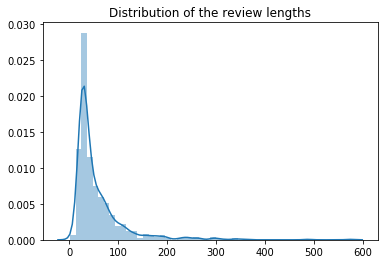

In [62]:
ax = plt.axes()
sns.distplot(review_lengths)
ax.set_title("Distribution of the review lengths")
plt.plot()

In [63]:
pd.DataFrame(review_lengths).describe()

,0
count,800.000000
mean,57.431250
std,55.240267
min,2.000000
25%,27.000000
50%,37.000000
75%,68.000000
max,574.000000


In [17]:
#Adding padding to each review less than max_length and cutting off reviews greater than max length
max_length = 200

train_ids, z = utils.pad_np_array(train_id_list, max_len=200) 
test_ids, z = utils.pad_np_array(test_id_list, max_len=200) 

In [97]:
print(train_ids.shape)

(800, 200)


In [14]:
print(train_ids[0])

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 12 10 16 17 18 19 20  7 21 22 10 23
 24 25 26 27 28  6 29 10 30 31 12 32 33 13 12 34 35 36 36 37 38 19 39 32 26
  9 40 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [26]:

print(len(train_ids))
print(len(X_train))
print(train_ids[0:100])
print(X_train[0:2])

219753
800
[   0  776   44 1112    2 1250  777   41  776    2 3275 2181 2181    2
    2   41 2498    2    2    2    2    2 2181 3776   44    2    2    2
   41 3275    2   44    2    2   10    2    2 3275 2181    2    2 2181
 1112    2 3873    2   41 1250    2   44 2498 3873    2  776   41    2
    2    2    2    2    2 2181    2    2 3873    2   41 1250   10    2
    2 3776 2181 2935    2 3873 2498 2028 1250    2 1112   44   41 1250
    2 1250 2181    2    2    2 1250    2    2    2    2 2181 1112 2498
    2 3776]
29     Saw this book in my local library.  Borrowed i...
535    i purchased this for a friend who enjoys cake ...
Name: reviewText, dtype: object


In [18]:
print(y_train.shape)
print(train_ids.shape)
print(test_ids.shape)

(800,)
(800, 200)
(200, 200)


In [19]:
lstm_size = 256
lstm_layers = 1
batch_size = 50
learning_rate = 0.001
embed_size = 200

In [37]:
def batch_iterator(ids, labels, batch_size=100):
    
    n_batches = len(ids)//batch_size
    ids, labels = ids[:n_batches*batch_size], labels[:n_batches*batch_size]
    
    for ii in range(0, len(ids), batch_size):
        yield ids[ii:ii+batch_size], labels[ii:ii+batch_size]
        

In [76]:
def build_rnn(gl_embed=hands.W,
              embed_size=embed_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              lstm_size=lstm_size,
              lstm_layers=lstm_layers):
    
    tf.reset_default_graph()
    
    #n_words = len(vocabulary_to_int)
    
    with tf.name_scope('inputs'):
        inputs_ = tf.placeholder(tf.int32,[None, None],name='inputs_')
    with tf.name_scope('labels'):
        labels_ = tf.placeholder(tf.int32,[None, None],name='labels_')
    with tf.name_scope('keep_prob'):    
        keep_prob = tf.placeholder(tf.float32,name='keep_prob')
        
    with tf.name_scope('embedding'):
#         embedding = tf.Variable(tf.random_normal((n_words,embed_size),-1,1),name='embedding_')
#         embed = tf.nn.embedding_lookup(embedding,inputs_)
        embedding=tf.get_variable(name="embedding_",shape=gl_embed.shape,
                                       initializer=tf.constant_initializer(gl_embed),trainable=False)
        embed = tf.nn.embedding_lookup(embedding, inputs_)
        
    with tf.name_scope("RNN_cells"):
        lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

        # Add dropout to the cell
        drop = tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob=keep_prob)

        # Stack up multiple LSTM layers, for deep learning
        cell = tf.contrib.rnn.MultiRNNCell([drop]*lstm_layers)
        
        with tf.name_scope("RNN_init_state"):
            # Getting an initial state of all zeros
            initial_state = cell.zero_state(batch_size, tf.float32)
    
    with tf.name_scope("RNN_forward"):
        outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)
        
    with tf.name_scope('predictions'):
        predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, 
                                                        activation_fn=tf.sigmoid,
                                                        weights_initializer=
                                                        tf.truncated_normal_initializer(stddev=0.1))   
    with tf.name_scope('cost'):
        cost = tf.losses.mean_squared_error(labels_, predictions)
        tf.summary.scalar('cost', cost)
    
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.name_scope('accuracy'):
        correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    merged = tf.summary.merge_all()
    
    # Export the nodes 
    export_nodes = ['inputs_', 'labels_','initial_state', 'final_state',
                    'keep_prob', 'cell', 'cost', 'predictions', 'optimizer',
                    'accuracy','merged']
    
    Graph = namedtuple('Graph', export_nodes)
    
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

In [77]:
graph = build_rnn(gl_embed=hands.W,
              embed_size=embed_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              lstm_size=lstm_size,
              lstm_layers=lstm_layers)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('output/logs/1', sess.graph)

MemoryError: 

In [53]:
print(y_test.shape)

(200,)


In [73]:


def train(model, epoch,train_writer,test_writer):
    
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        iteration = 1
        for e in range(epochs):
            state = sess.run(model.initial_state)

            for ii, (x, y) in enumerate(batch_iterator(train_ids, y_train, batch_size), 1):
                
                feed = {model.inputs_: x,
                        model.labels_: y[:, None],
                        model.keep_prob: 0.5,
                        model.initial_state: state}
                summary,loss, state, _ = sess.run([model.merged,model.cost, 
                                                   model.final_state, 
                                                   model.optimizer], feed_dict=feed)

                if iteration%5==0:
                    print("Epoch: {}/{}".format(e, epochs),
                          "Iteration: {}".format(iteration),
                          "Train loss: {:.3f}".format(loss))

                train_writer.add_summary(summary, iteration)

                if iteration%25==0:
                    val_acc = []
                    val_state = sess.run(model.cell.zero_state(batch_size, tf.float32))
                    for x, y in batch_iterator(test_ids, y_test, batch_size):
                        feed = {model.inputs_: x,
                                model.labels_: y[:, None],
                                model.keep_prob: 1,
                                model.initial_state: val_state}
                        summary, batch_acc, val_state = sess.run([model.merged,model.accuracy, 
                                                         model.final_state], feed_dict=feed)
                        #print('batch_acc', batch_acc)
                        val_acc.append(batch_acc)

                    test_writer.add_summary(summary,iteration)
                    print("Val acc: {:.3f}".format(np.mean(val_acc)))

                iteration +=1
        saver.save(sess, "output/checkpoints/sentiment.ckpt")

In [60]:
print(test_ids)

[[  41  195    4 ...,    0    0    0]
 [  41 2656    6 ...,    0    0    0]
 [  41  101   44 ...,    0    0    0]
 ..., 
 [   7  970   15 ...,    0    0    0]
 [  41   52    4 ...,    0    0    0]
 [ 142 1744  288 ...,    0    0    0]]


In [48]:
lstm_size_options = [256]
lstm_layers_options = [1]
learning_rate_options = [0.001]

In [74]:
epochs = 1
batch_size=50
for lstm_size in lstm_size_options:
    for lstm_layers in lstm_layers_options:
        for learning_rate in learning_rate_options:
            log_string_train = 'output/logs/2/train/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            log_string_test = 'output/logs/2/test/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            train_writer = tf.summary.FileWriter(log_string_train)
            test_writer = tf.summary.FileWriter(log_string_test)
            
            print("lstm size: {}".format(lstm_size),
                    "nb layers : {}".format(lstm_layers),
                    "learn rate : {:.3f}".format(learning_rate))
            
            model = build_rnn(gl_embed=hands.W,
                      embed_size=embed_size,
                      batch_size=batch_size,
                      learning_rate=learning_rate,
                      lstm_size=lstm_size,
                      lstm_layers=lstm_layers)

            train(model, epochs, train_writer,test_writer)

lstm size: 256 nb layers : 1 learn rate : 0.001
Epoch: 0/1 Iteration: 5 Train loss: 0.166
Epoch: 0/1 Iteration: 10 Train loss: 0.186
Epoch: 0/1 Iteration: 15 Train loss: 0.233


In [75]:
epochs = 5
batch_size=50
for lstm_size in lstm_size_options:
    for lstm_layers in lstm_layers_options:
        for learning_rate in learning_rate_options:
            log_string_train = 'output/logs/2/train/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            log_string_test = 'output/logs/2/test/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            train_writer = tf.summary.FileWriter(log_string_train)
            test_writer = tf.summary.FileWriter(log_string_test)
            
            print("lstm size: {}".format(lstm_size),
                    "nb layers : {}".format(lstm_layers),
                    "learn rate : {:.3f}".format(learning_rate))
            
            model = build_rnn(gl_embed=hands.W,
                      embed_size=embed_size,
                      batch_size=batch_size,
                      learning_rate=learning_rate,
                      lstm_size=lstm_size,
                      lstm_layers=lstm_layers)

            train(model, epochs, train_writer,test_writer)

lstm size: 256 nb layers : 1 learn rate : 0.001
Epoch: 0/5 Iteration: 5 Train loss: 0.164
Epoch: 0/5 Iteration: 10 Train loss: 0.178
Epoch: 0/5 Iteration: 15 Train loss: 0.237
Epoch: 1/5 Iteration: 20 Train loss: 0.208
Epoch: 1/5 Iteration: 25 Train loss: 0.127
Val acc: 0.790
Epoch: 1/5 Iteration: 30 Train loss: 0.238
Epoch: 2/5 Iteration: 35 Train loss: 0.175
Epoch: 2/5 Iteration: 40 Train loss: 0.170
Epoch: 2/5 Iteration: 45 Train loss: 0.202
Epoch: 3/5 Iteration: 50 Train loss: 0.157
Val acc: 0.790
Epoch: 3/5 Iteration: 55 Train loss: 0.166
Epoch: 3/5 Iteration: 60 Train loss: 0.158
Epoch: 4/5 Iteration: 65 Train loss: 0.116
Epoch: 4/5 Iteration: 70 Train loss: 0.147
Epoch: 4/5 Iteration: 75 Train loss: 0.122
Val acc: 0.790
Epoch: 4/5 Iteration: 80 Train loss: 0.124
